
# Initial Contact Detection

This example can be referenced by citing the package.

The example illustrates how the initial contact detection (ICD) algorithm is used to detect initial contacts using body acceleration recorded with a triaxial accelerometer worn or fixed on the lower back. The initial contact detection algorithm is implemented in the main module `NGMT\ngmt\modules\ICDA.py`.

The algorithm takes accelerometer data as input, specifically the vertical acceleration component, and processes each specified gait sequence independently. The algorithm requires the start and end time of each gait sequence, in the format provided by the Gait Sequence detection algorithm (`NGMT\ngmt\modules\GSDA.py`). Gait sequences are provided as a list of dictionaries with 'Start' and 'End' fields indicating the start and end times of each sequence. The sampling frequency of the accelerometer data is also required.

For each gait sequence, the algorithm applies the Signal Decomposition Algorithm for Initial Contacts (ICs). In case of successful detection, the identified ICs are added to the corresponding gait sequence dictionary under the key 'IC'. If the algorithm encounters an error during the signal decomposition process, it prints an error message and returns an empty list of ICs for that sequence.

The algorithm handles multiple gait sequences and ensures uniform output by padding the IC lists with NaN values to match the length of the sequence with the maximum number of ICs detected among all sequences. The final processed output is a list of dictionaries containing information about each gait sequence, including the detected ICs.

Additionally, the algorithm provides an option to plot the results. The processed acceleration signal, along with the detected initial contacts, is visualized for each gait sequence.

## Import libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset (mobilised), gait sequence detection module (GSDB), and initial contact detection module (ICDA) are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the 'ngmt' library and its dependencies if you haven't already.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ngmt.config import cfg_colors
from ngmt.datasets import mobilised
from ngmt.modules import GSDB, ICDA

## Data Preparation

To implement the initial contact algorithm, we load example data from a congestive heart failure (CHF) cohort, which is publicly available on the Zenodo repository [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7547125.svg)](https://doi.org/10.5281/zenodo.7547125). 

The participant was assessed for 2.5 hours in the real-world while doing different daily life activities and also was asked to perform specific tasks such as outdoor walking, walking up and down a slope and stairs and moving from one room to another [`1`].

Since we will use norm of the accleration signal to detect gait sequences, we don't need to take care of orientation of the signal.

Refertences

.. [`1`] Mazzà, Claudia, et al. "Technical validation of real-world monitoring of gait: a multicentric observational study." BMJ open 11.12 (2021): e050785. http://dx.doi.org/10.1136/bmjopen-2021-050785


## Visualisation of the Data
The raw acceleration data including components of x, y and z axis is represented.

In [2]:
# This code snippet loads motion data from a MATLAB file
# The 'file_path' variable holds the absolute path to the data file
# The 'mobilised.load_file' function is used to load the data from the specified file
file_path = r'C:\Users\Project\Desktop\Gait_Sequence\Mobilise-D dataset_1-18-2023\CHF\data.mat'
motion_data = mobilised.load_file(file_path=file_path)

In [3]:
# Get the recording data
# The 'motion_data' object contains recorded motion data. We're interested in a single tracked point (lower back).

# Since we only have a single tracked point (lower back)
# The recorded data is organized by tracked points. Here, we access the data for the lower back, which is typically at index 0.
recording_data = motion_data.data[0]

# Select only accelerometer data
# We are interested in the accelerometer data, so we need to identify the relevant channels.
# We'll identify accelerometer channels based on their names.

# Create a list of indices (idx_sel) for the accelerometer channels by iterating through the channel names.
idx_sel = [idx for idx, ch_name in enumerate(recording_data.channels.name)
           if "ACCEL" in ch_name]

# Extract the accelerometer data from the recording data
# We use the 'idx_sel' list to select the corresponding columns from the data.
acceleration_data = recording_data.data[:, idx_sel]

# Get the corresponding sampling frequency
# The 'recording_data' object contains information about the recorded data, including its sampling frequency.
sampling_frequency = recording_data.sampling_frequency

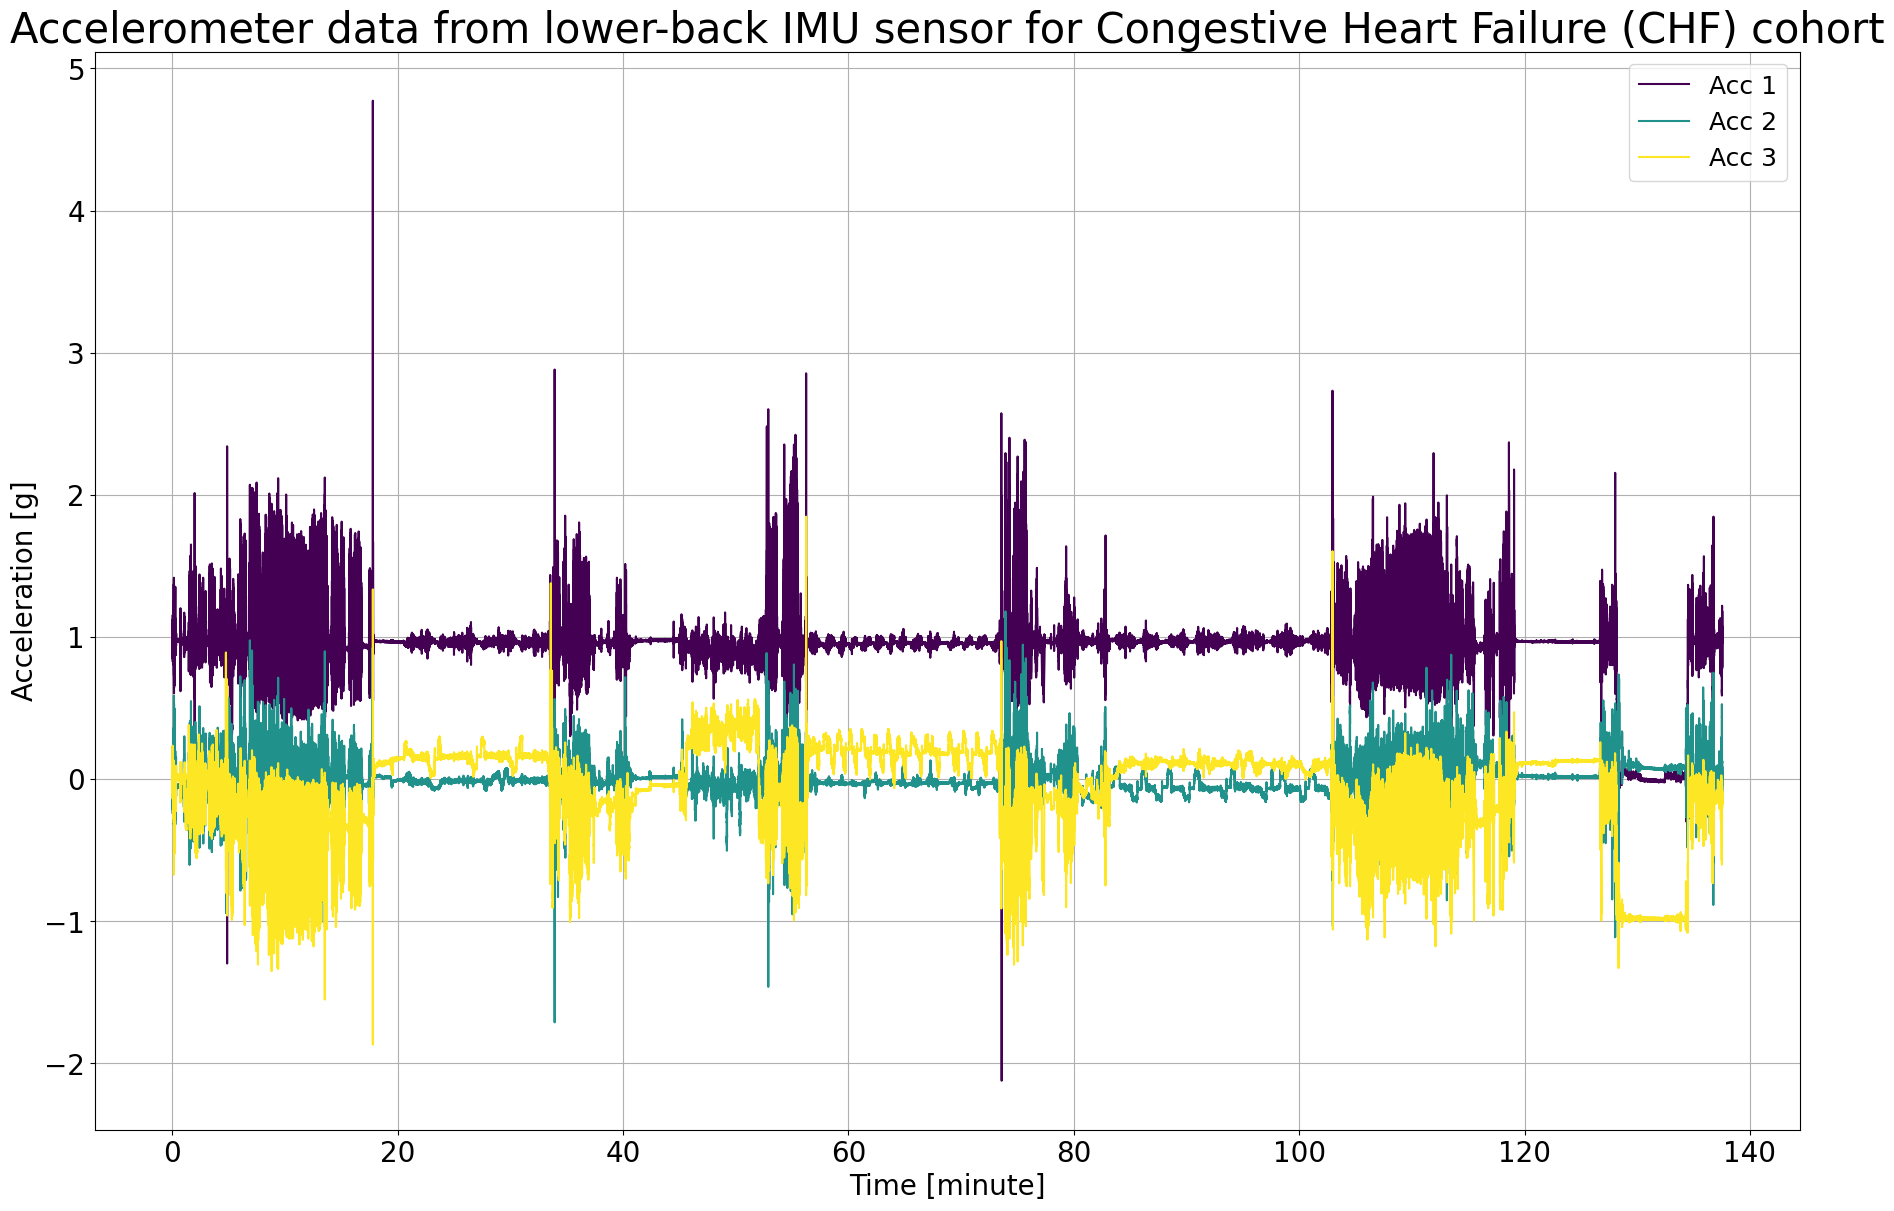

In [4]:
# Calculate the time values in minutes
# The 'time_in_minute' array represents time values in minutes, computed based on the length of 'acceleration_data' and 'sampling_frequency'.
time_in_minute = np.arange(len(acceleration_data)) / (60 * sampling_frequency)

# Create a figure with a specified size
plt.figure(figsize=(22, 14))

# Get colors for raw
colors = cfg_colors['raw']

# A loop is used to plot data for each accelerometer axis, applying different colors from the color map.
for i in range(3):
    plt.plot(time_in_minute, acceleration_data[:, i], color=colors[i], label=f'Acc {i + 1}')

# Add labels and legends
plt.xlabel("Time [minute]", fontsize=20)  
plt.ylabel("Acceleration [g]", fontsize=20)  
plt.legend(fontsize=18) 

# Add a title with a specified font size
plt.title("Accelerometer data from lower-back IMU sensor for Congestive Heart Failure (CHF) cohort", fontsize=30)

# Customize tick font sizes
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  #

# Display a grid for reference
plt.grid(visible=None, which='both', axis='both') 

# Show the plot
plt.show() 

Let's zoom in on specific time periods in the data, particularly the first 10 seconds, where clear blinks are evident.

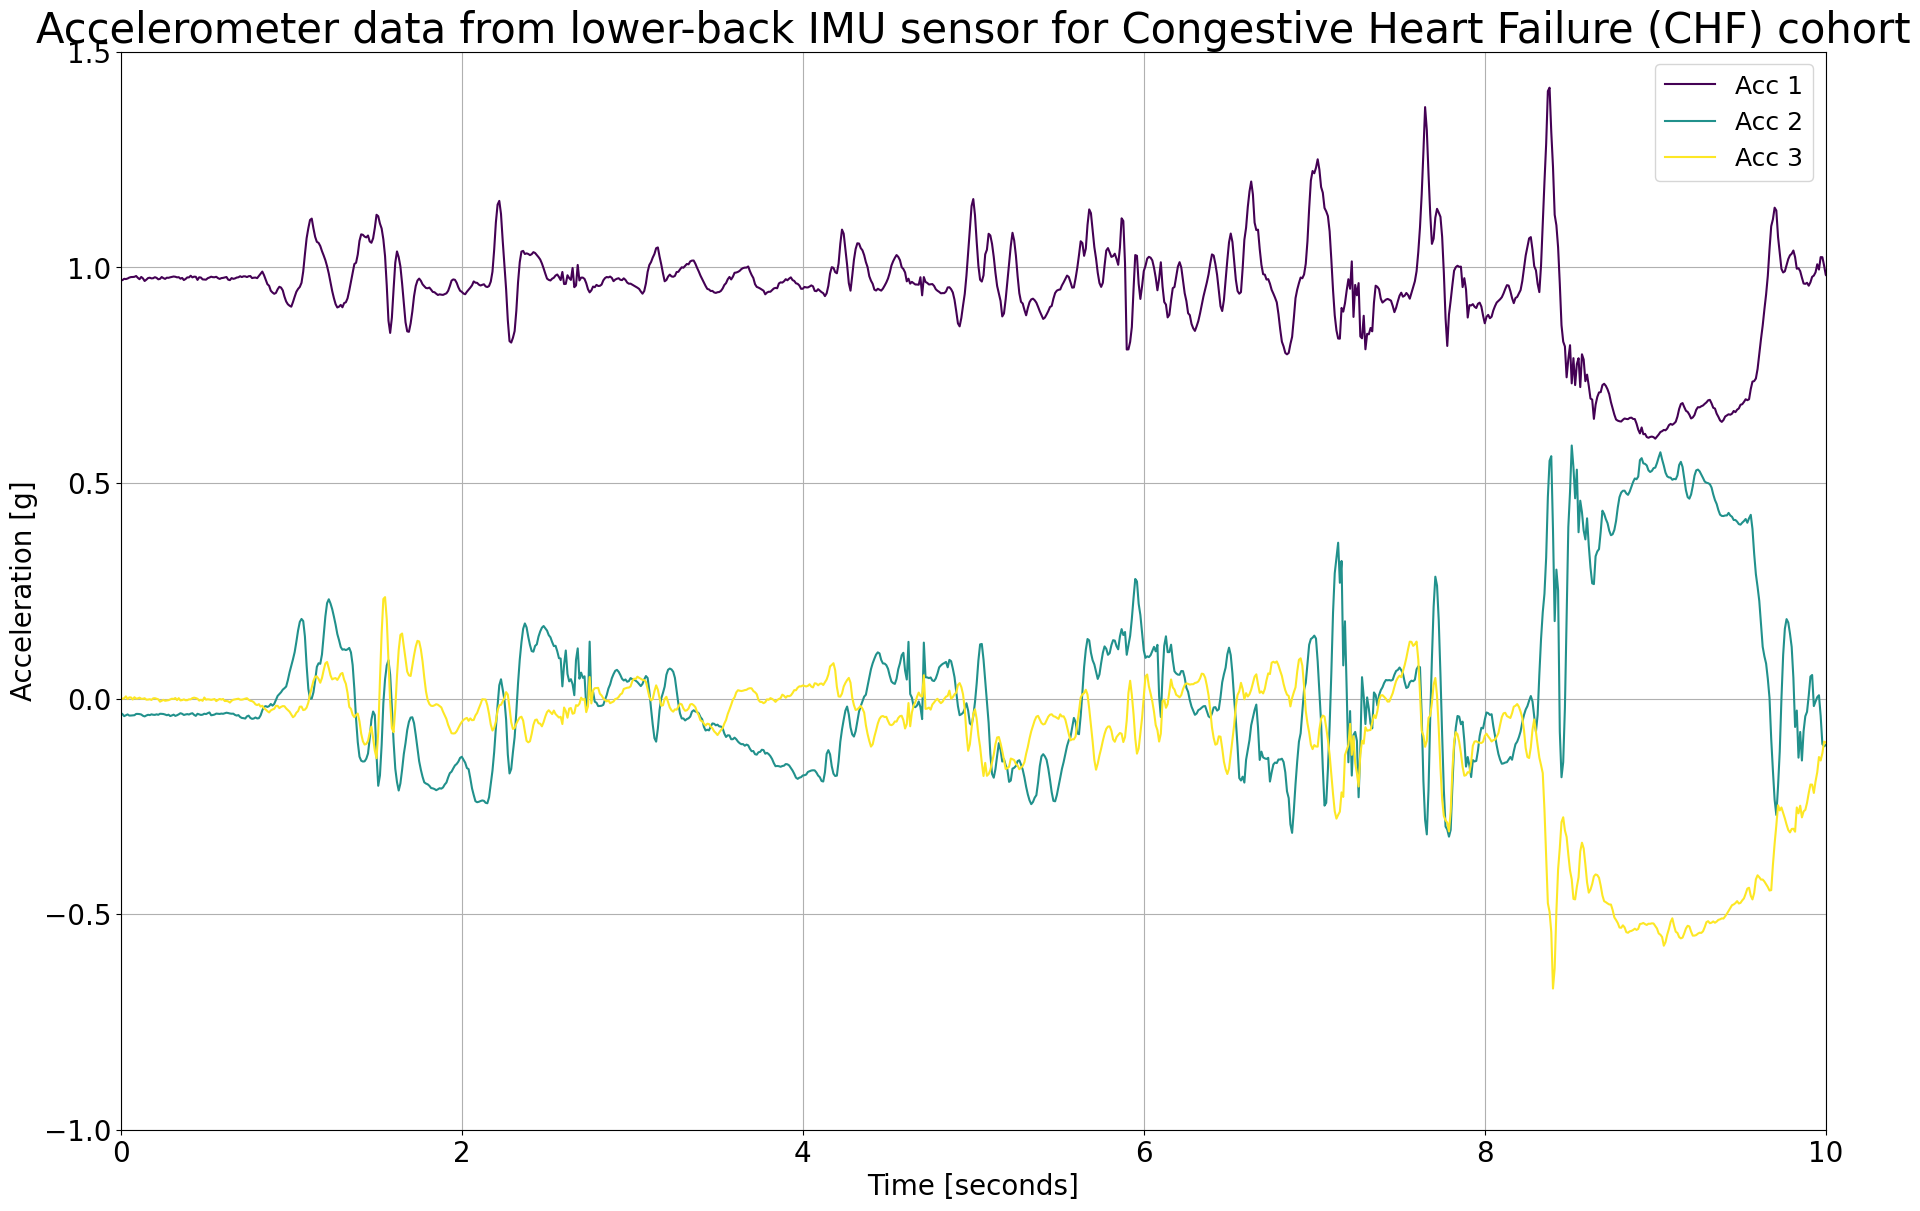

In [5]:
# Calculate the time values based on the length of the data
num_samples = len(acceleration_data)
time_seconds = np.arange(num_samples) / sampling_frequency

# Create a figure with the specified size
plt.figure(figsize=(22, 14))

# Plot acceleration data for each axis with time on the x-axis
for i in range(3):
    plt.plot(time_seconds, acceleration_data[:, i], color=colors[i], label=f'Acc {i + 1}')

# Add labels and legends
plt.xlabel("Time [seconds]", fontsize=20)
plt.ylabel("Acceleration [g]", fontsize=20)
plt.legend(fontsize=18)

# Add a title
plt.title("Accelerometer data from lower-back IMU sensor for Congestive Heart Failure (CHF) cohort", fontsize=30)

# Customize font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Set x-axis and y-axis limits for a specific duration (in seconds) and acceleration range
plt.xlim(0, 10)
plt.ylim(-1, 1.5)

# Display a grid for reference
plt.grid(visible=None, which='both', axis='both')  # Add a grid for reference

# Show the plot
plt.show() 

## Applying the initial contact detection algorithm
Now, we are running initial contact detection (ICD) algorithm from main module (`NGMT.ngmt.modules.ICDA.Initial_Contact_Detection`) to detect initial contacts throughout the detected gait sequences. The first inputs is gait sequences which is provided as a list of dictionaries with 'Start' and 'End'. They were detected using gait sequence detection algorithm (GSDB) using `NGMT.ngmt.modules.GSD.Gait_Sequence_Detection`. The other inputs of the function are the initial sampling frequency of the accelerometer data and a plot option. Optionally, if the plot_results flag is set to True, a visualization plot is generated to display the preprocessed data and the detected initial contacts.
The output is the detected gait sequences containing start and end time along with the initial contacts which are shown as a list.

In [6]:
# The results of the gait sequence detection algorithm is used to detect initial contacts.
# Consequently, before running initial contact detection algorithm, the gait sequence detetction algorithm have to be runned on acceleretion signal.
# Use Gait_Sequence_Detection to detect gait sequence 
gait_sequences = GSDB.Gait_Sequence_Detection(imu_acceleration=acceleration_data, sampling_frequency=sampling_frequency, plot_results=False)

# Now, use Initial_Contact_Detection to detect initial contacts within detected gait sequences.
initial_contacts = ICDA.Initial_Contact_Detection(imu_acceleration=acceleration_data, gait_sequences=gait_sequences, sampling_frequency=sampling_frequency, plot_results=False)

# Display the detected initial contacts using ICDA algorithm.
# Print the start and end times along with the list of initial contacts.
for i in initial_contacts:
    print(f"Detected gait sequenced and their corresponding initial contacts:")
    print(f"Start Time: {i['Start']} seconds")
    print(f"End Time: {i['End']} seconds")
    print(f"Initial Contacts: {i['IC']} seconds")

Gait sequence(s) detected.
Detected gait sequenced and their corresponding initial contacts:
Start Time: 4.5 seconds
End Time: 9.75 seconds
Initial Contacts: [5.0, 5.6, 6.525, 7.0, 7.6, 8.225] seconds
Detected gait sequenced and their corresponding initial contacts:
Start Time: 90.225 seconds
End Time: 100.525 seconds
Initial Contacts: [90.6, 91.225, 91.8, 92.375, 92.975, 94.225, 94.85, 95.975, 96.6, 97.125, 97.64999999999999, 98.225, 98.77499999999999, 99.32499999999999, 99.875] seconds
Detected gait sequenced and their corresponding initial contacts:
Start Time: 106.075 seconds
End Time: 111.675 seconds
Initial Contacts: [106.47500000000001, 107.15, 107.75, 108.325, 108.925, 109.575, 110.275, 111.05] seconds
Detected gait sequenced and their corresponding initial contacts:
Start Time: 116.225 seconds
End Time: 126.575 seconds
Initial Contacts: [116.8, 118.475, 119.05, 119.85, 120.35, 121.07499999999999, 121.55, 122.07499999999999, 122.625, 123.14999999999999, 123.69999999999999, 124.

To better understand the concept of the detected initial contacts, let’s take a closer look at the raw acceleration data. Let's zoom in on specific time periods in the raw acceleration data, particularly the first detected gait sequence and its corresponding initial contacts. 

To get a better understanding of the results, the raw acceleration data, detected first gait sequence and its corresponding initial contacts are plotted. The green and red vertical lines show the start and end of the first gait sequence. The vertical blue line are representing detected initial contacts within the first gait sequence.

The detected initial contacts in the first gait sequence:
Start Time: 4.5 seconds
End Time: 9.75 seconds
Initial Contacts: [5.0, 5.6, 6.525, 7.0, 7.6, 8.225] seconds


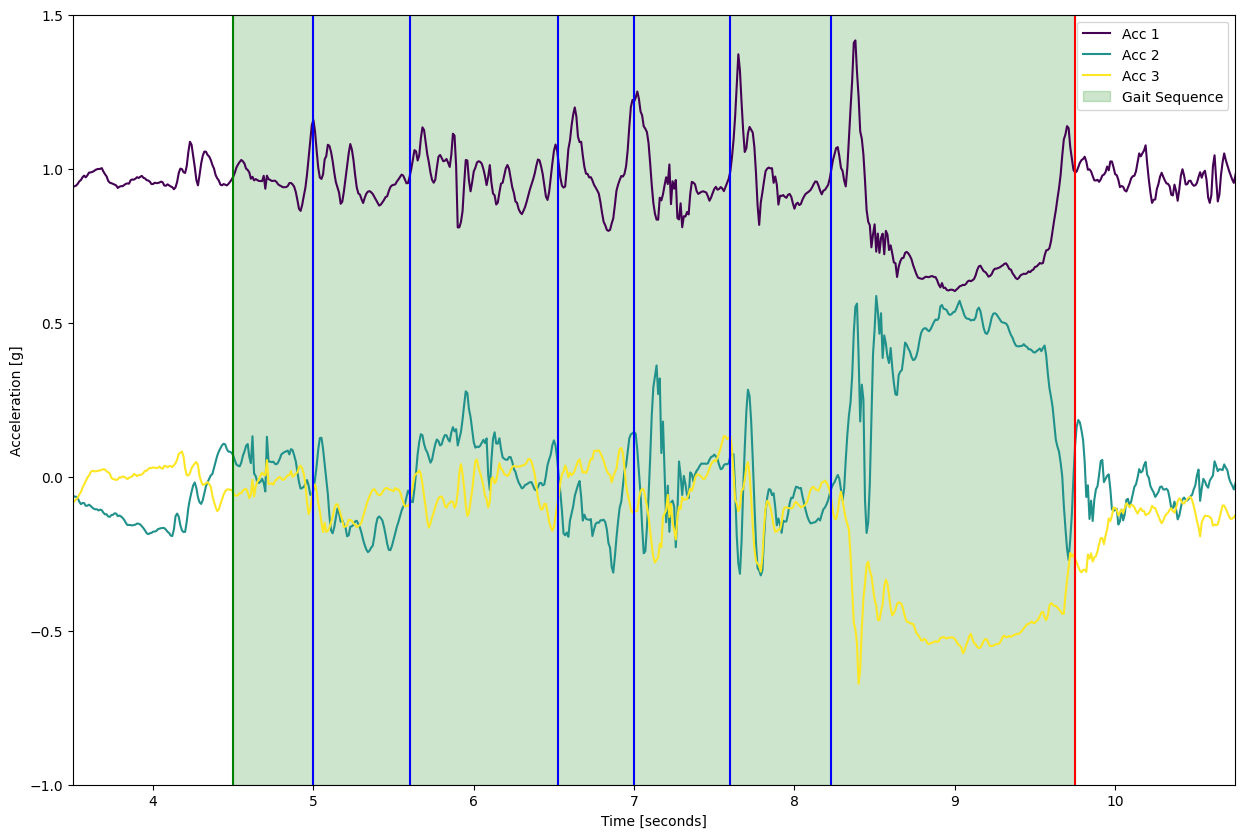

In [7]:
# Display the detected initial contacts in the first gait sequence
print(f"The detected initial contacts in the first gait sequence:")
print(f"Start Time: {initial_contacts[0]['Start']} seconds")
print(f"End Time: {initial_contacts[0]['End']} seconds")
print(f"Initial Contacts: {initial_contacts[0]['IC']} seconds")

# Create a figure and axis for plotting the raw data from the lower back
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the results
for i in range(3):
    ax.plot(time_seconds, acceleration_data[:, i], color=colors[i], label=f'Acc {i + 1}')

# Plot the detected initial contacts in the first gait sequence if they exist
if gait_sequences:
    first_gait_sequence = gait_sequences[0]
    ax.axvspan(first_gait_sequence['Start'], first_gait_sequence['End'], alpha=0.2, color='green', label='Gait Sequence')
    plt.axvline(gait_sequences[0]['Start'], color="g")
    plt.axvline(gait_sequences[0]['End'], color="r")
    # Set x-axis limits
    start_limit = first_gait_sequence['Start'] - 1
    end_limit = first_gait_sequence['End'] + 1
    ax.set_xlim(start_limit, end_limit)

# Plot the round circles for the initial contacts
initial_contacts = initial_contacts[0]['IC']
for contact_time in initial_contacts:
    ax.axvline(contact_time, color='blue')
ax.legend('Initial Contact')
ax.set_ylim(-1, 1.5)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('Acceleration [g]')

# Add legend and show the plot
ax.legend()
plt.show()